In [2]:
import submitit
import os
import glob
import numpy as np
import pandas as pd
import mne
import submitit
import mne
import numpy as np
from tensorpac import Pac
import matplotlib.pyplot as plt
import os
import urllib
import pandas as pd
import numpy as np
from scipy.io import loadmat

from tensorpac import Pac, EventRelatedPac, PreferredPhase
from tensorpac.utils import PeakLockedTF, PSD, ITC, BinAmplitude


In [8]:
pid = 'd213e786-4b1c-477d-a710-766d69fa1ac1'



def bin_amplitude(pid, n_jobs = 5):

    epoch_path = f'/mnt/data/AdaptiveControl/IBLrawdata/pid_data/{pid}/lfp_{pid}_epoched.fif'



    # Load metadata

    # Load the epochs
    epochs = mne.read_epochs(epoch_path, preload=True)
    sf = epochs.info['sfreq']
    meta = epochs.metadata.reset_index()
    for i, ch in enumerate(epochs.ch_names):
        
        # if i >0:
        #     break 
    # Select specific channels

        epoch = epochs.copy().pick_channels([ch])

        
        # Extract data from epochs
        data = epoch.get_data().squeeze()  # Shape: (n_epochs, n_channels, n_times)
        # Define condition trials based on the condition parameter
        stim_indices = np.where(((meta['contrastLeft'] > 0.2) | (meta['contrastRight'] > 0.2)))[0]
        # Select data for each condition
        data = data[stim_indices]
        
        time_0_250ms = slice(0, 250)
        time_250_500ms = slice(250, 500)
        time_500_1000ms = slice(500, 1000)
        time_1000_1500ms = slice(1000, 1500)

        # define phase and amplitude filtering properties
        kw_filt = dict(f_pha=[2, 8], f_amp=[20, 80], n_bins=18, edges= 10, n_jobs= n_jobs) 
        # bin the rest, planning and execution periods. Note that ideally, the entire
        # trial should be filtered and then binning should be performed
        bin_0_250ms = BinAmplitude(data[:, time_0_250ms], sf, **kw_filt)
        bin_250_500ms = BinAmplitude(data[:, time_250_500ms], sf, **kw_filt)
        bin_500_1000ms = BinAmplitude(data[:, time_500_1000ms], sf, **kw_filt)
        bin_1000_1500ms = BinAmplitude(data[:, time_1000_1500ms], sf, **kw_filt)



        plt.figure(figsize=(16, 5))
        # bin 0-250ms period
        plt.subplot(1, 4, 1)
        bin_0_250ms.plot(normalize=True, color='gray', unit='deg')
        plt.ylim(0.5, 1.2), plt.title("-1, -0.5", fontsize=18)

        # bin 250-500ms period
        plt.subplot(1, 4, 2)
        bin_250_500ms.plot(normalize=True, unit='deg')
        plt.ylim(0.5, 1.2), plt.ylabel(''), plt.title("-0.5 , 0", fontsize=18)

        # bin 500-1000ms period
        plt.subplot(1, 4, 3)
        bin_500_1000ms.plot(normalize=True, color='red', unit='deg')
        plt.ylim(0.5, 1.2), plt.ylabel(''), plt.title("0, 1 s", fontsize=18)

        # bin 1000-1500ms period
        plt.subplot(1, 4, 4)
        bin_1000_1500ms.plot(normalize=True, color='red', unit='deg')
        plt.ylim(0.5, 1.2), plt.ylabel(''), plt.title("1, 2 s", fontsize=18)

        plt.tight_layout()
        plt.savefig(f'/crnldata/cophy/TeamProjects/mohammad/ibl-oscillations/_analyses/_IBLworkflows/PAC/figures/bin_amp/{pid}_{ch}.png')
        
        
path = '/crnldata/cophy/TeamProjects/mohammad/ibl-oscillations/_analyses/_IBLworkflows/preprocessing/clean_data.csv'
df = pd.read_csv(path)
pids = df['pid'].values

for pid in pids:
    
    executor = submitit.AutoExecutor(folder="logs")
    # pass parameter to the executor
    executor.update_parameters(mem_gb=20, timeout_min=600, slurm_partition="CPU", cpus_per_task=5)
    # execute the job (note the .map_array command that different from the .submit command used above)
    jobs = executor.submit(bin_amplitude, pid)



Binning [20, 80]Hz amplitude according to [2, 8]Hz phase


Binning [20, 80]Hz amplitude according to [2, 8]Hz phase
Binning [20, 80]Hz amplitude according to [2, 8]Hz phase
Binning [20, 80]Hz amplitude according to [2, 8]Hz phase


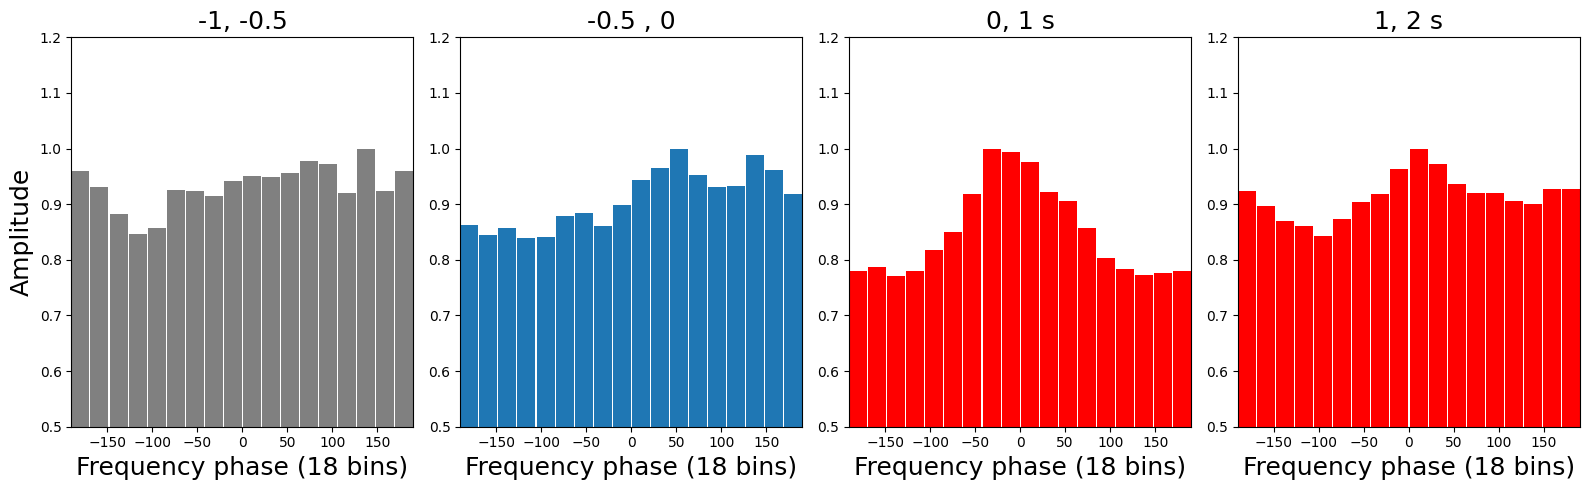

In [112]:
time_0_250ms = slice(0, 250)
time_250_500ms = slice(250, 500)
time_500_1000ms = slice(500, 1000)
time_1000_1500ms = slice(1000, 1500)

# define phase and amplitude filtering properties
kw_filt = dict(f_pha=[2, 8], f_amp=[20, 80], n_bins=18, edges= 10 )
# bin the rest, planning and execution periods. Note that ideally, the entire
# trial should be filtered and then binning should be performed
bin_0_250ms = BinAmplitude(data[:, time_0_250ms], sf, **kw_filt)
bin_250_500ms = BinAmplitude(data[:, time_250_500ms], sf, **kw_filt)
bin_500_1000ms = BinAmplitude(data[:, time_500_1000ms], sf, **kw_filt)
bin_1000_1500ms = BinAmplitude(data[:, time_1000_1500ms], sf, **kw_filt)



plt.figure(figsize=(16, 5))
# bin 0-250ms period
plt.subplot(1, 4, 1)
bin_0_250ms.plot(normalize=True, color='gray', unit='deg')
plt.ylim(0.5, 1.2), plt.title("-1, -0.5", fontsize=18)

# bin 250-500ms period
plt.subplot(1, 4, 2)
bin_250_500ms.plot(normalize=True, unit='deg')
plt.ylim(0.5, 1.2), plt.ylabel(''), plt.title("-0.5 , 0", fontsize=18)

# bin 500-1000ms period
plt.subplot(1, 4, 3)
bin_500_1000ms.plot(normalize=True, color='red', unit='deg')
plt.ylim(0.5, 1.2), plt.ylabel(''), plt.title("0, 1 s", fontsize=18)

# bin 1000-1500ms period
plt.subplot(1, 4, 4)
bin_1000_1500ms.plot(normalize=True, color='red', unit='deg')
plt.ylim(0.5, 1.2), plt.ylabel(''), plt.title("1, 2 s", fontsize=18)

plt.tight_layout()
plt.show()

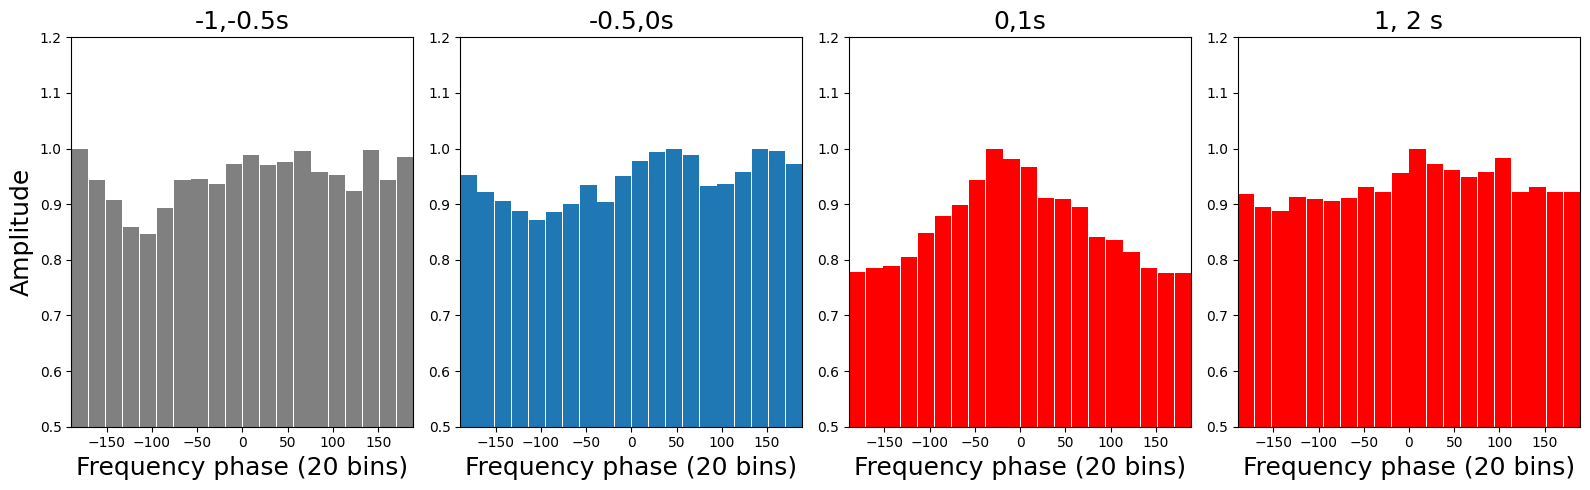

In [90]:
plt.figure(figsize=(16, 5))
# bin 0-250ms period
plt.subplot(1, 4, 1)
bin_0_250ms.plot(normalize=True, color='gray', unit='deg')
plt.ylim(0.5, 1.2), plt.title("-1,-0.5s", fontsize=18)

# bin 250-500ms period
plt.subplot(1, 4, 2)
bin_250_500ms.plot(normalize=True, unit='deg')
plt.ylim(0.5, 1.2), plt.ylabel(''), plt.title("-0.5,0s", fontsize=18)

# bin 500-1000ms period
plt.subplot(1, 4, 3)
bin_500_1000ms.plot(normalize=True, color='red', unit='deg')
plt.ylim(0.5, 1.2), plt.ylabel(''), plt.title("0,1s", fontsize=18)

# bin 1000-1500ms period
plt.subplot(1, 4, 4)
bin_1000_1500ms.plot(normalize=True, color='red', unit='deg')
plt.ylim(0.5, 1.2), plt.ylabel(''), plt.title("1, 2 s", fontsize=18)

plt.tight_layout()
plt.show()


Binning [20, 80]Hz amplitude according to [2, 8]Hz phase
Binning [20, 80]Hz amplitude according to [2, 8]Hz phase
Binning [20, 80]Hz amplitude according to [2, 8]Hz phase
Binning [20, 80]Hz amplitude according to [2, 8]Hz phase
Binning [20, 80]Hz amplitude according to [2, 8]Hz phase
Binning [20, 80]Hz amplitude according to [2, 8]Hz phase


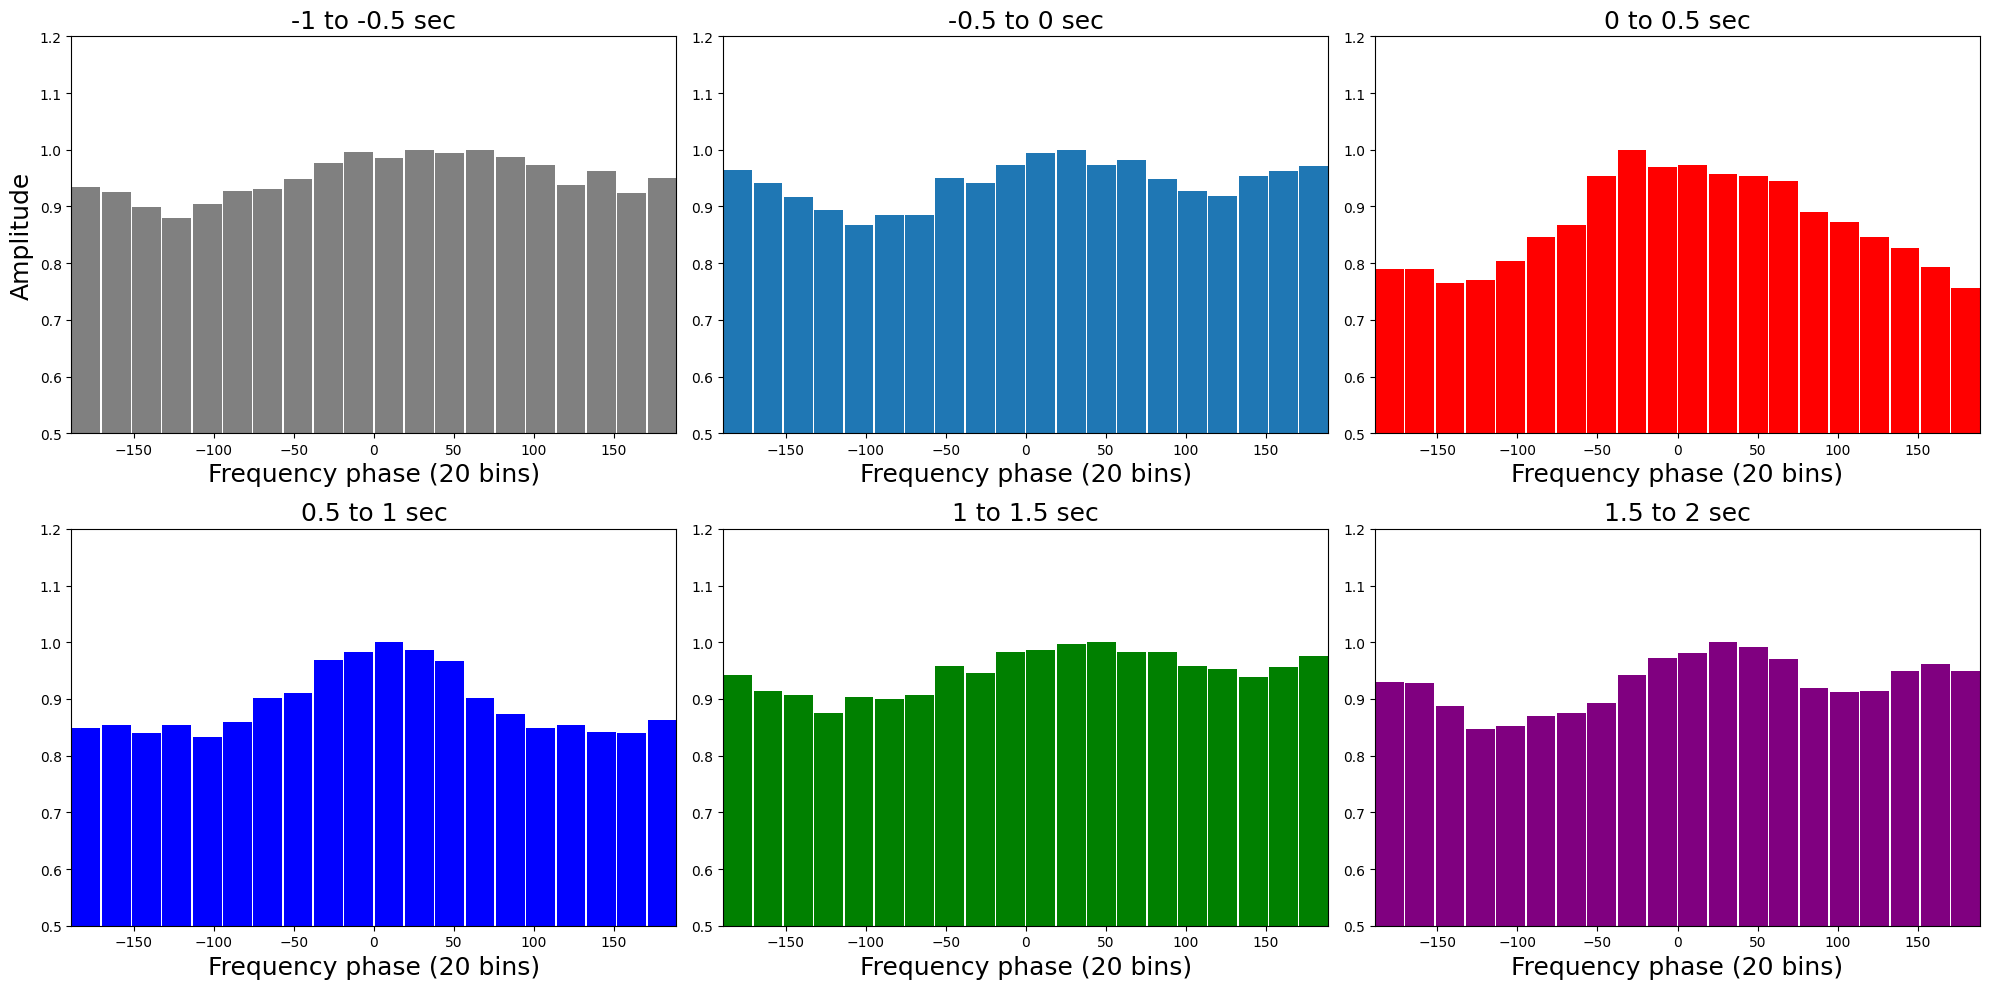

In [89]:
# Define time slices in sample indices
time_neg1_to_neg0_5_sec = slice(0, 250)      # corresponds to -1 to -0.5 seconds
time_neg0_5_to_0_sec = slice(250, 500)       # corresponds to -0.5 to 0 seconds
time_0_to_0_5_sec = slice(500, 750)          # corresponds to 0 to 0.5 seconds
time_0_5_to_1_sec = slice(750, 1000)         # corresponds to 0.5 to 1 seconds
time_1_to_1_5_sec = slice(1000, 1250)        # corresponds to 1 to 1.5 seconds
time_1_5_to_2_sec = slice(1250, 1500)        # corresponds to 1.5 to 2 seconds

# Define phase and amplitude filtering properties
kw_filt = dict(f_pha=[2, 8], f_amp=[20, 80], n_bins=20)

# Bin the amplitude for each time interval
bin_neg1_to_neg0_5_sec = BinAmplitude(data[:, time_neg1_to_neg0_5_sec], sf, **kw_filt)
bin_neg0_5_to_0_sec = BinAmplitude(data[:, time_neg0_5_to_0_sec], sf, **kw_filt)
bin_0_to_0_5_sec = BinAmplitude(data[:, time_0_to_0_5_sec], sf, **kw_filt)
bin_0_5_to_1_sec = BinAmplitude(data[:, time_0_5_to_1_sec], sf, **kw_filt)
bin_1_to_1_5_sec = BinAmplitude(data[:, time_1_to_1_5_sec], sf, **kw_filt)
bin_1_5_to_2_sec = BinAmplitude(data[:, time_1_5_to_2_sec], sf, **kw_filt)

plt.figure(figsize=(20, 10))

# Bin -1 to -0.5 seconds period
plt.subplot(2, 3, 1)
bin_neg1_to_neg0_5_sec.plot(normalize=True, color='gray', unit='deg')
plt.ylim(0.5, 1.2), plt.title("-1 to -0.5 sec", fontsize=18)

# Bin -0.5 to 0 seconds period
plt.subplot(2, 3, 2)
bin_neg0_5_to_0_sec.plot(normalize=True, unit='deg')
plt.ylim(0.5, 1.2), plt.ylabel(''), plt.title("-0.5 to 0 sec", fontsize=18)

# Bin 0 to 0.5 seconds period
plt.subplot(2, 3, 3)
bin_0_to_0_5_sec.plot(normalize=True, color='red', unit='deg')
plt.ylim(0.5, 1.2), plt.ylabel(''), plt.title("0 to 0.5 sec", fontsize=18)

# Bin 0.5 to 1 seconds period
plt.subplot(2, 3, 4)
bin_0_5_to_1_sec.plot(normalize=True, color='blue', unit='deg')
plt.ylim(0.5, 1.2), plt.ylabel(''), plt.title("0.5 to 1 sec", fontsize=18)

# Bin 1 to 1.5 seconds period
plt.subplot(2, 3, 5)
bin_1_to_1_5_sec.plot(normalize=True, color='green', unit='deg')
plt.ylim(0.5, 1.2), plt.ylabel(''), plt.title("1 to 1.5 sec", fontsize=18)

# Bin 1.5 to 2 seconds period
plt.subplot(2, 3, 6)
bin_1_5_to_2_sec.plot(normalize=True, color='purple', unit='deg')
plt.ylim(0.5, 1.2), plt.ylabel(''), plt.title("1.5 to 2 sec", fontsize=18)

plt.tight_layout()
plt.show()


In [18]:
import numpy as np

from tensorpac.signals import pac_signals_wavelet
from tensorpac.utils import PeakLockedTF

import matplotlib.pyplot as plt


pid = 'd213e786-4b1c-477d-a710-766d69fa1ac1'



def aligne_phase(pid, n_jobs = 5):

    epoch_path = f'/mnt/data/AdaptiveControl/IBLrawdata/pid_data/{pid}/lfp_{pid}_epoched.fif'



    # Load metadata

    # Load the epochs
    epochs = mne.read_epochs(epoch_path, preload=True)
    times = epochs.times
    sf = epochs.info['sfreq']
    meta = epochs.metadata.reset_index()
    for i, ch in enumerate(epochs.ch_names):
        
        # if i >0:
        #     break 
    # Select specific channels

        epoch = epochs.copy().pick_channels([ch])

        
        # Extract data from epochs
        data = epoch.get_data().squeeze()  # Shape: (n_epochs, n_channels, n_times)
        # Define condition trials based on the condition parameter
        stim_indices = np.where(((meta['contrastLeft'] > 0.2) | (meta['contrastRight'] > 0.2)))[0]
        # Select data for each condition
        data = data[stim_indices]
        
        cue = 0.                 # time-point of reference (in seconds)
        f_pha = [2, 7]           # single frequency phase interval
        f_amp = (20, 60, 3, 1)  # amplitude frequencies
        p_obj = PeakLockedTF(data, sf, cue, times=times, f_pha=f_pha, f_amp= f_amp)
        plt.figure(figsize=(8, 9))
        title = 'Peak-Locked TF representation according to phase 2 - 7 Hz'
        p_obj.plot(zscore=True, vmin=-1, vmax=1, cmap='Spectral_r')
        p_obj.savefig(f'/crnldata/cophy/TeamProjects/mohammad/ibl-oscillations/_analyses/_IBLworkflows/PAC/figures/aligned_freqs/{pid}_{ch}.png')
        # note that it is also possible to perform a z-score normalization to
        # compensate the natural 1 / f effect in the power of real data. In that case
        # the power is centered around 0
        # p_obj.plot(zscore=True, vmin=-1, vmax=1, cmap='Spectral_r')

        # plt.tight_layout()
        # p_obj.show()
        # plt.savefig(f'/crnldata/cophy/TeamProjects/mohammad/ibl-oscillations/_analyses/_IBLworkflows/PAC/figures/aligned_freqs/{pid}_{ch}.png')
        # plt.show()
        
        
path = '/crnldata/cophy/TeamProjects/mohammad/ibl-oscillations/_analyses/_IBLworkflows/preprocessing/clean_data.csv'
df = pd.read_csv(path)
pids = df['pid'].values

for i, pid in enumerate (pids):
    
    if i == 0:
        continue
    
    executor = submitit.AutoExecutor(folder="logs")
    # pass parameter to the executor
    
    executor.update_parameters(mem_gb=20, timeout_min=600, slurm_partition="CPU", cpus_per_task=1)
    # execute the job (note the .map_array command that different from the .submit command used above)
    jobs = executor.submit(aligne_phase, pid)




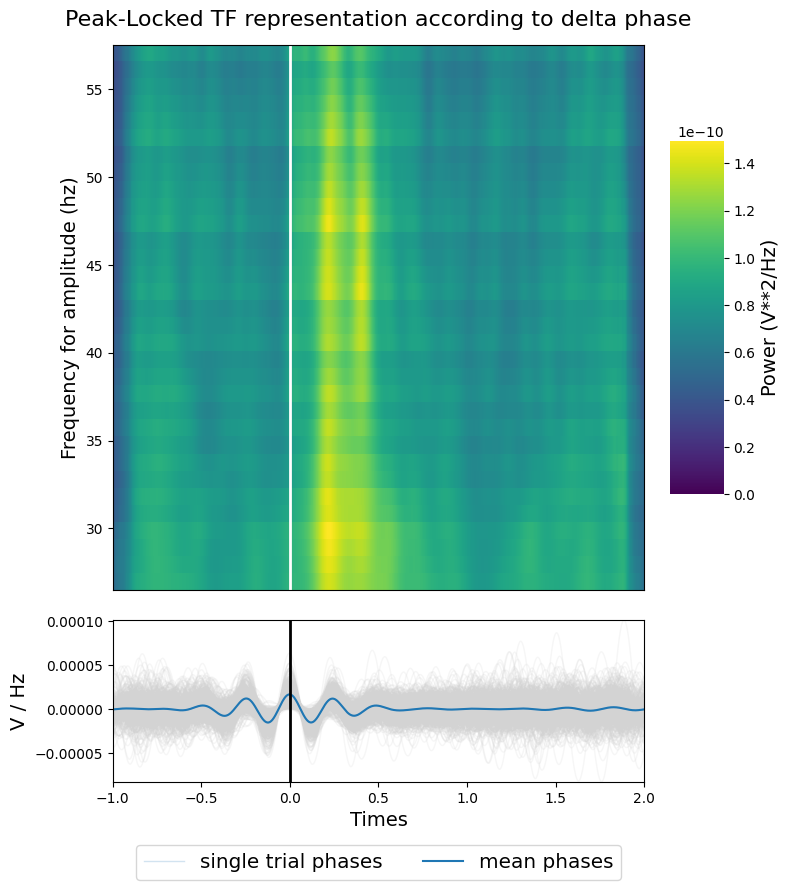

In [61]:
plt.figure(figsize=(8, 9))
title = 'Peak-Locked TF representation according to delta phase'
p_obj.plot(vmin=0, cmap='viridis', title=title)

# note that it is also possible to perform a z-score normalization to
# compensate the natural 1 / f effect in the power of real data. In that case
# the power is centered around 0
# p_obj.plot(zscore=True, vmin=-1, vmax=1, cmap='Spectral_r')

plt.tight_layout()
p_obj.show()

/tmp/ipykernel_124634/3221059855.py:6: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epoch.get_data().squeeze()
Phase Amplitude Coupling object defined


    true PAC estimation using Gaussian Copula PAC (gcPac)
    compute surrogates (Swap amplitude time blocks (Bahramisharif et al. 2013), 200 permutations, random_state=6002)
    infer p-values at (p=0.05, mcp=maxstat)
    normalize true PAC estimation by surrogates (Substract then divide by the mean of surrogates)
    true PAC estimation using Gaussian Copula PAC (gcPac)
    compute surrogates (Swap amplitude time blocks (Bahramisharif et al. 2013), 200 permutations, random_state=843)
    infer p-values at (p=0.05, mcp=maxstat)
    normalize true PAC estimation by surrogates (Substract then divide by the mean of surrogates)
    true PAC estimation using Gaussian Copula PAC (gcPac)
    compute surrogates (Swap amplitude time blocks (Bahramisharif et al. 2013), 200 permutations, random_state=8221)
    infer p-values at (p=0.05, mcp=maxstat)
    normalize true PAC estimation by surrogates (Substract then divide by the mean of surrogates)


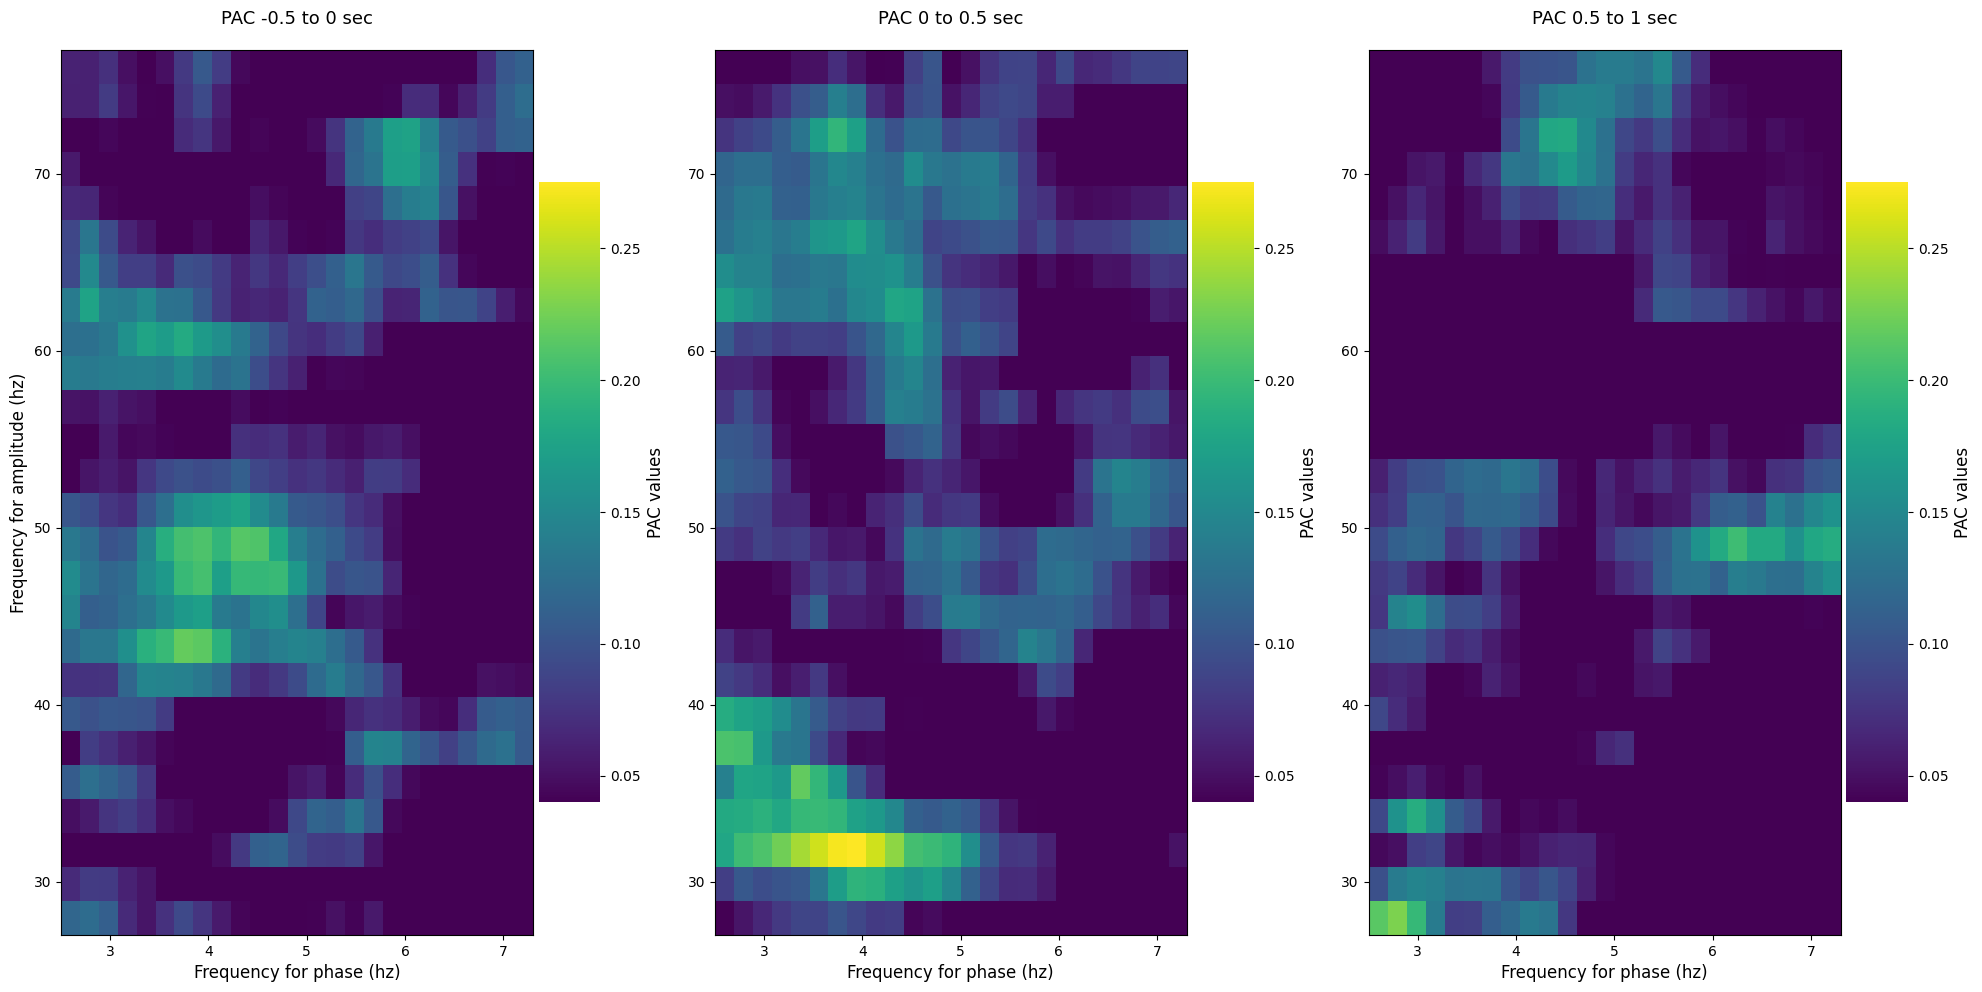

In [95]:
import numpy as np
import matplotlib.pyplot as plt
from tensorpac import Pac

# Assuming epoch, sf, and stim_indices are defined
data = epoch.get_data().squeeze()
data = data[stim_indices]
data = data[:, 250:1000]  # Selecting data between -0.5s to 1s

p_obj = Pac(idpac=(6, 2, 3), f_pha=(2, 8, 1, .2), f_amp=(25, 80, 4, 2))

# Extract all of the phases and amplitudes
pha_p = p_obj.filter(sf, data, ftype='phase')
amp_p = p_obj.filter(sf, data, ftype='amplitude')

# Define time indices where rest, planning, and execution are defined
time_neg0_5_to_0_sec = slice(0, 250)    # corresponds to -0.5 to 0 seconds
time_0_to_0_5_sec = slice(250, 500)     # corresponds to 0 to 0.5 seconds
time_0_5_to_1_sec = slice(500, 750)     # corresponds to 0.5 to 1 seconds

# Define phase / amplitude during different time intervals
pha_2, amp_2 = pha_p[..., time_neg0_5_to_0_sec], amp_p[..., time_neg0_5_to_0_sec]
pha_3, amp_3 = pha_p[..., time_0_to_0_5_sec], amp_p[..., time_0_to_0_5_sec]
pha_4, amp_4 = pha_p[..., time_0_5_to_1_sec], amp_p[..., time_0_5_to_1_sec]

# Compute PAC inside different time intervals
pac_2 = p_obj.fit(pha_2, amp_2).mean(-1)
pac_3 = p_obj.fit(pha_3, amp_3).mean(-1)
pac_4 = p_obj.fit(pha_4, amp_4).mean(-1)

# Determine the maximum PAC value for consistent color scaling
vmax = np.max([pac_2.max(), pac_3.max(), pac_4.max()])
kw = dict(vmax=vmax, vmin=.04, cmap='viridis')

# Plotting the PAC comodulograms for each time interval
plt.figure(figsize=(20, 10))

plt.subplot(131)
p_obj.comodulogram(pac_2, title="PAC -0.5 to 0 sec", **kw)

plt.subplot(132)
p_obj.comodulogram(pac_3, title="PAC 0 to 0.5 sec", **kw)
plt.ylabel('')

plt.subplot(133)
p_obj.comodulogram(pac_4, title="PAC 0.5 to 1 sec", **kw)
plt.ylabel('')

plt.tight_layout()
plt.show()


/tmp/ipykernel_124634/504202872.py:6: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epoch.get_data().squeeze()
Phase Amplitude Coupling object defined
    true PAC estimation using Gaussian Copula PAC (gcPac)
    compute surrogates (Permute phase across trials (Tort et al. 2010), 200 permutations, random_state=7621)
    infer p-values at (p=0.05, mcp=maxstat)
    true PAC estimation using Gaussian Copula PAC (gcPac)
    compute surrogates (Permute phase across trials (Tort et al. 2010), 200 permutations, random_state=8734)
    infer p-values at (p=0.05, mcp=maxstat)
    true PAC estimation using Gaussian Copula PAC (gcPac)
    compute surrogates (Permute phase across trials (Tort et al. 2010), 200 permutations, random_state=3524)
    infer p-values at (p=0.05, mcp=maxstat)


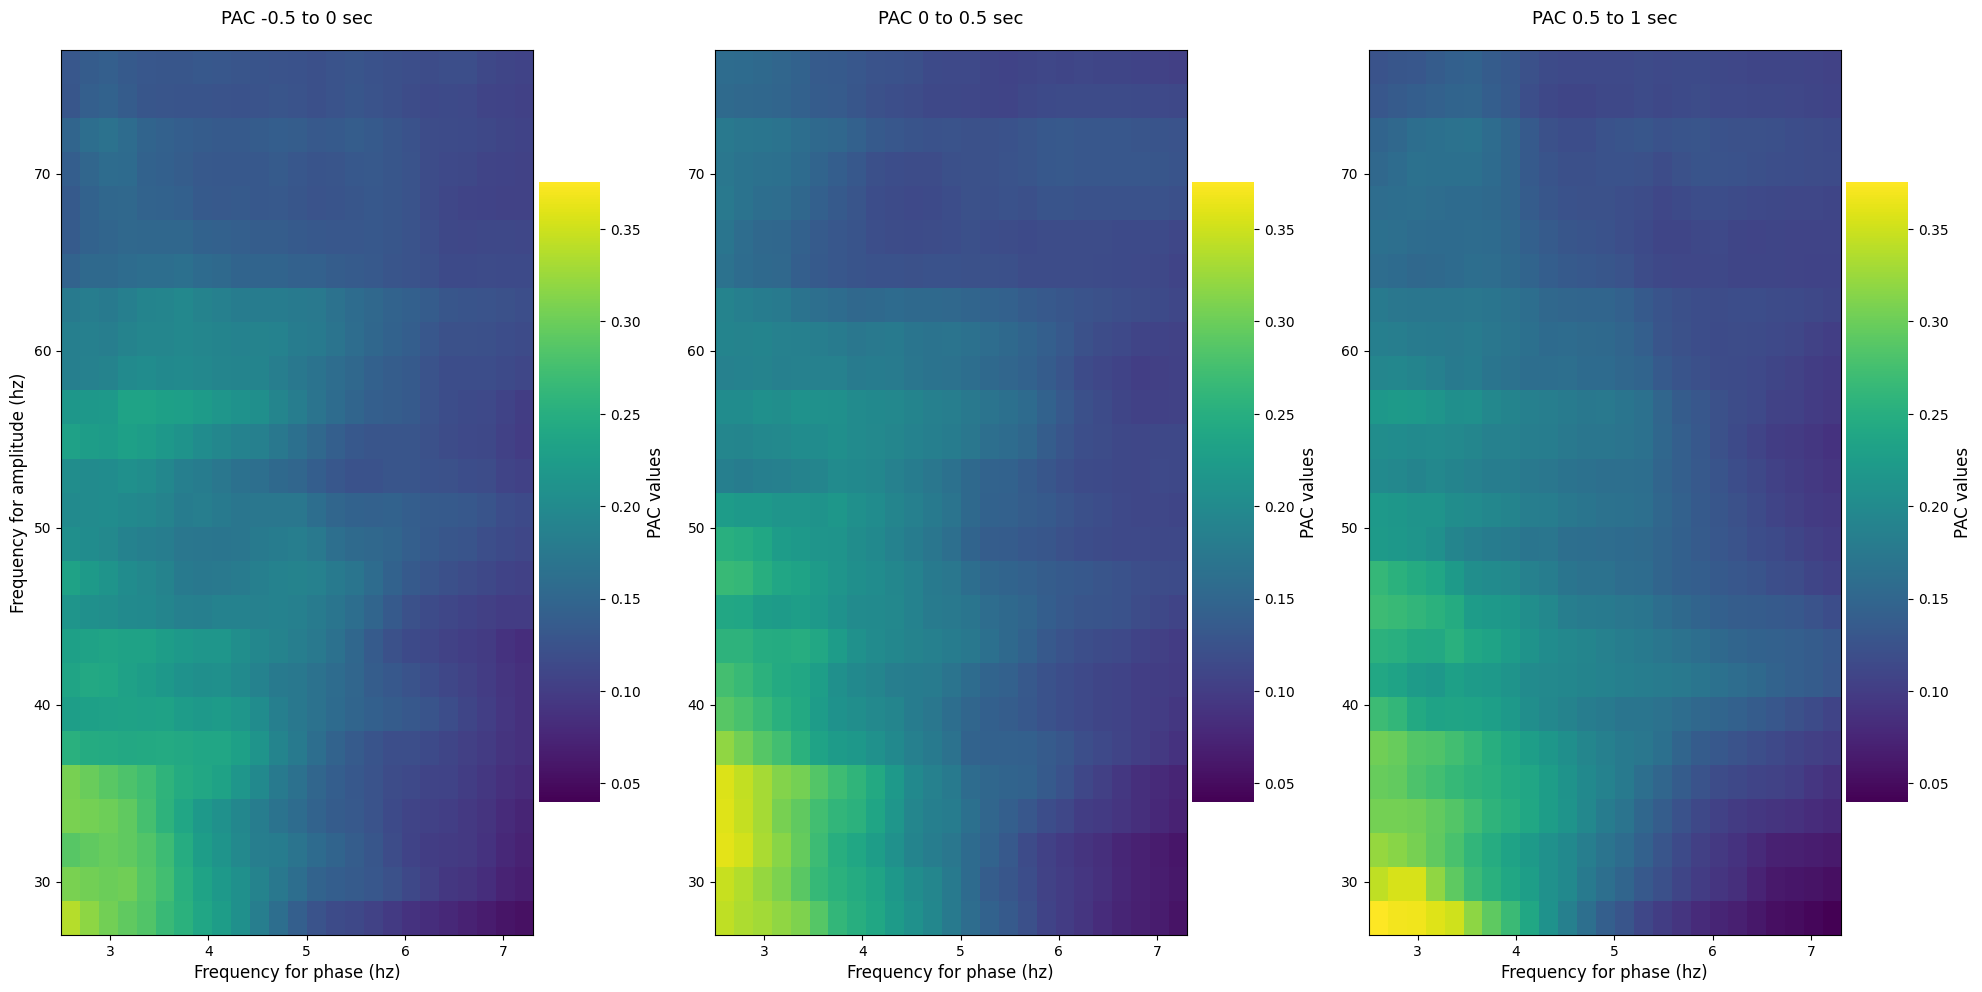

In [108]:
import numpy as np
import matplotlib.pyplot as plt
from tensorpac import Pac

# Assuming epoch, sf, and stim_indices are defined
data = epoch.get_data().squeeze()
data = data[stim_indices]
data = data[:, 250:1000]  # Selecting data between -0.5s to 1s

p_obj = Pac(idpac=(6, 1, 0), f_pha=(2, 8, 1, .2), f_amp=(25, 80, 4, 2))

# Extract all of the phases and amplitudes
pha_p = p_obj.filter(sf, data, ftype='phase')
amp_p = p_obj.filter(sf, data, ftype='amplitude')

# Define time indices where rest, planning, and execution are defined
time_neg0_5_to_0_sec = slice(0, 250)    # corresponds to -0.5 to 0 seconds
time_0_to_0_5_sec = slice(250, 500)     # corresponds to 0 to 0.5 seconds
time_0_5_to_1_sec = slice(500, 750)     # corresponds to 0.5 to 1 seconds

# Define phase / amplitude during different time intervals
pha_2, amp_2 = pha_p[..., time_neg0_5_to_0_sec], amp_p[..., time_neg0_5_to_0_sec]
pha_3, amp_3 = pha_p[..., time_0_to_0_5_sec], amp_p[..., time_0_to_0_5_sec]
pha_4, amp_4 = pha_p[..., time_0_5_to_1_sec], amp_p[..., time_0_5_to_1_sec]

# Compute PAC inside different time intervals
pac_2 = p_obj.fit(pha_2, amp_2).mean(-1)
pac_3 = p_obj.fit(pha_3, amp_3).mean(-1)
pac_4 = p_obj.fit(pha_4, amp_4).mean(-1)

# Determine the maximum PAC value for consistent color scaling
vmax = np.max([pac_2.max(), pac_3.max(), pac_4.max()])
kw = dict(vmax=vmax, vmin=.04, cmap='viridis')

# Plotting the PAC comodulograms for each time interval
plt.figure(figsize=(20, 10))

plt.subplot(131)
p_obj.comodulogram(pac_2, title="PAC -0.5 to 0 sec", **kw)

plt.subplot(132)
p_obj.comodulogram(pac_3, title="PAC 0 to 0.5 sec", **kw)
plt.ylabel('')

plt.subplot(133)
p_obj.comodulogram(pac_4, title="PAC 0.5 to 1 sec", **kw)
plt.ylabel('')

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorpac import Pac
pid = 'd213e786-4b1c-477d-a710-766d69fa1ac1'


epoch_path = f'/mnt/data/AdaptiveControl/IBLrawdata/pid_data/{pid}/lfp_{pid}_epoched.fif'



# Load metadata

# Load the epochs
epochs = mne.read_epochs(epoch_path, preload=True)
times = epochs.times

sf = epochs.info['sfreq']
meta = epochs.metadata.reset_index()
for i, ch in enumerate(epochs.ch_names):
    
    if i ==0:
        continue 

    epoch = epochs.copy().pick_channels([ch])

    # Assuming epoch, sf, and stim_indices are defined
    data = epoch.get_data().squeeze()
    data = data[stim_indices]
    data = data[:, 250:1000]  # Selecting data between -0.5s to 1s

    p_obj = Pac(idpac=(6, 3, 1), f_pha=(2, 8, 1, .2), f_amp=(25, 80, 4, 2))

    # Extract all of the phases and amplitudes
    pha_p = p_obj.filter(sf, data, ftype='phase')
    amp_p = p_obj.filter(sf, data, ftype='amplitude')

    # Define time indices where rest, planning, and execution are defined
    time_neg0_5_to_0_sec = slice(0, 250)    # corresponds to -0.5 to 0 seconds
    time_0_to_0_5_sec = slice(250, 500)     # corresponds to 0 to 0.5 seconds
    time_0_5_to_1_sec = slice(500, 750)     # corresponds to 0.5 to 1 seconds

    # Define phase / amplitude during different time intervals
    pha_2, amp_2 = pha_p[..., time_neg0_5_to_0_sec], amp_p[..., time_neg0_5_to_0_sec]
    pha_3, amp_3 = pha_p[..., time_0_to_0_5_sec], amp_p[..., time_0_to_0_5_sec]
    pha_4, amp_4 = pha_p[..., time_0_5_to_1_sec], amp_p[..., time_0_5_to_1_sec]

    # Compute PAC inside different time intervals
    pac_2 = p_obj.fit(pha_2, amp_2).mean(-1)
    pac_3 = p_obj.fit(pha_3, amp_3).mean(-1)
    pac_4 = p_obj.fit(pha_4, amp_4).mean(-1)

    # Determine the maximum PAC value for consistent color scaling
    vmax = np.max([pac_2.max(), pac_3.max(), pac_4.max()])
    kw = dict(vmax=vmax, vmin=.04, cmap='viridis')

    # Plotting the PAC comodulograms for each time interval
    plt.figure(figsize=(20, 10))

    plt.subplot(131)
    p_obj.comodulogram(pac_2, title=f"{ch} PAC -0.5 to 0 sec", **kw)

    plt.subplot(132)
    p_obj.comodulogram(pac_3, title="PAC 0 to 0.5 sec", **kw)
    plt.ylabel('')

    plt.subplot(133)
    p_obj.comodulogram(pac_4, title="PAC 0.5 to 1 sec", **kw)
    plt.ylabel('')

    plt.tight_layout()
    plt.show()


Reading /mnt/data/AdaptiveControl/IBLrawdata/pid_data/d213e786-4b1c-477d-a710-766d69fa1ac1/lfp_d213e786-4b1c-477d-a710-766d69fa1ac1_epoched.fif ...


/tmp/ipykernel_166094/2363012943.py:14: RuntimeWarning: This filename (/mnt/data/AdaptiveControl/IBLrawdata/pid_data/d213e786-4b1c-477d-a710-766d69fa1ac1/lfp_d213e786-4b1c-477d-a710-766d69fa1ac1_epoched.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epoch_path, preload=True)


Isotrak not found
    Found the data of interest:
        t =   -1000.00 ...    2000.00 ms
        0 CTF compensation matrices available
Adding metadata with 16 columns
577 matching events found
No baseline correction applied
0 projection items activated
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_166094/2363012943.py:25: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epoch.get_data().squeeze()
Phase Amplitude Coupling object defined
    extract phases (n_pha=35) and amplitudes (n_amps=80)
    true PAC estimation using Gaussian Copula PAC (gcPac)


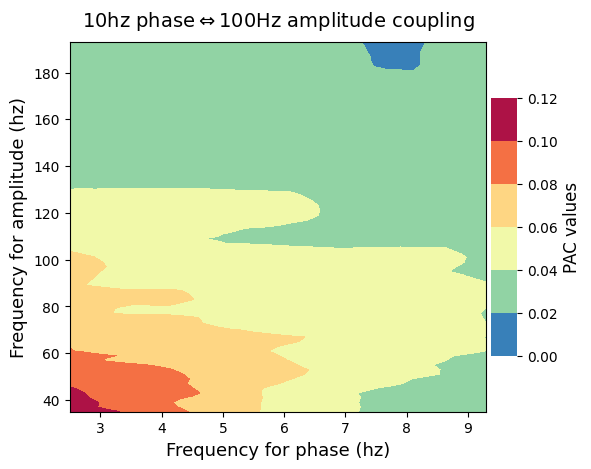

In [11]:
pid = 'd213e786-4b1c-477d-a710-766d69fa1ac1'

from tensorpac import Pac
from tensorpac.signals import pac_signals_tort

import matplotlib.pyplot as plt
epoch_path = f'/mnt/data/AdaptiveControl/IBLrawdata/pid_data/{pid}/lfp_{pid}_epoched.fif'



# Load metadata

# Load the epochs
epochs = mne.read_epochs(epoch_path, preload=True)
times = epochs.times

sf = epochs.info['sfreq']
meta = epochs.metadata.reset_index()
for i, ch in enumerate(epochs.ch_names):
    
    if i >0:
        break
    epoch = epochs.copy().pick_channels([ch])

data = epoch.get_data().squeeze()
data =data[:, 500:1000]

# Define a Pac object
p = Pac(idpac=(6, 0, 0), f_pha=(2, 10, 1, .2), f_amp=(30, 200, 10, 2))
# Filter the data and extract pac
xpac = p.filterfit(sf, data)

# plot your Phase-Amplitude Coupling :
p.comodulogram(xpac.mean(-1), cmap='Spectral_r', plotas='contour', ncontours=5,
               title=r'10hz phase$\Leftrightarrow$100Hz amplitude coupling',
               fz_title=14, fz_labels=13)
# export the figure
# plt.savefig('readme.png', bbox_inches='tight', dpi=300)
p.show()